**Тестовое задание на Аналитика X5**

Задание: Классификация отзывов клиентов

Выполнил: Попов Кирилл

# Используемые функции

In [93]:
def lim_normal_range(series_filtred, rnd = 1):
    # series_filtred - столбец датафрейма.
    # rnd - количество знаков, до которых буду округлять
    # По умолчанию до 1 знака после запятой

    q2=series_filtred.describe()[4]
    q3=series_filtred.describe()[6]
    min_column_name = series_filtred.describe()[3]
    max_column_name = series_filtred.describe()[7]

    x1 = round(max(min_column_name,  q2 - 1.5 * (q3 - q2) ), rnd)
    x2 = round(min(max_column_name,  q3 + 1.5 * (q3 - q2) ), rnd)
    return x1, x2

# Библиотеки

In [94]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from datetime import date
import plotly.express as px
import re
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Подготовка данных

In [95]:
# Загружаем данные
#df = pd.read_csv('/Users/kirill/Downloads/database X5/database_df.csv')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Тестовое X5/database_df.csv')

In [96]:
# Вызов метода info()
df.info()
# Первые 5 столбцов
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57050 entries, 0 to 57049
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed_0     57050 non-null  int64  
 1   shop          57050 non-null  object 
 2   order_number  57050 non-null  object 
 3   date          57050 non-null  object 
 4   status        57050 non-null  object 
 5   review        57050 non-null  float64
 6   feedback      19447 non-null  object 
 7   text_1        701 non-null    object 
 8   text_2        0 non-null      float64
 9   other_text    6401 non-null   object 
dtypes: float64(2), int64(1), object(7)
memory usage: 4.4+ MB


,Unnamed_0,shop,order_number,date,status,review,feedback,text_1,text_2,other_text
0,0,store_00,42811R65031404,2011-06-19 00:00:56,Не проверен,5.0,NaN,NaN,NaN,NaN
1,1,store_01,143171885R0421,2011-06-19 00:05:42,Не проверен,5.0,NaN,NaN,NaN,NaN
2,2,store_02,50488R51918131,2011-06-19 00:08:19,Не проверен,5.0,NaN,NaN,NaN,NaN
3,3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3.0,долго заказ ждал... хотя доставку оплату повыс...,NaN,NaN,NaN
4,4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3.0,NaN,NaN,NaN,Без описания


Удалю Unnamed_0 и заменю тип данных у даты и у object. Также text_2 у нас пустой

In [97]:
# Удалю Unnamed_0
df = df.drop(['Unnamed_0'], axis  = 1)

# Изменение формата дат
df['date'] = pd.to_datetime(df['date'])

# Изменение форматов столбцов
columns_to_str = ['shop','order_number','status','feedback','text_1','text_2','other_text']
for column in columns_to_str:
    df[column] = df[column].astype("string")

# Вызов метода info()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57050 entries, 0 to 57049
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   shop          57050 non-null  string        
 1   order_number  57050 non-null  string        
 2   date          57050 non-null  datetime64[ns]
 3   status        57050 non-null  string        
 4   review        57050 non-null  float64       
 5   feedback      19447 non-null  string        
 6   text_1        701 non-null    string        
 7   text_2        0 non-null      string        
 8   other_text    6401 non-null   string        
dtypes: datetime64[ns](1), float64(1), string(7)
memory usage: 3.9 MB


In [98]:
print('\n Проверка пропусков:')
display(df.isna().sum()) # подсчёт пропусков

print('\n Проверка явных дубликатов:', df.duplicated().sum())


 Проверка пропусков:


shop                0
order_number        0
date                0
status              0
review              0
feedback        37603
text_1          56349
text_2          57050
other_text      50649
dtype: int64


 Проверка явных дубликатов: 0


Данные готовы

# Анализ данных

### Магазины и заказы

In [99]:
df.shop.unique()

<StringArray>
[  'store_00',   'store_01',   'store_02',   'store_03',   'store_04',
   'store_05',   'store_06',   'store_07',   'store_08',   'store_09',
 ...
 'store_0562', 'store_0563', 'store_0564', 'store_0565', 'store_0566',
 'store_0567', 'store_0568', 'store_0569', 'store_0570', 'store_0571']
Length: 572, dtype: string

Мы имеем информацию о 572 магазинах

In [100]:
print('Всего было выполнено',df.order_number.count(),'заказов')

Всего было выполнено 57050 заказов


In [101]:
shops_info = (
    df.groupby("shop")
    .agg(
        {
            "order_number": "nunique",
            "review": ["min", "max", "median"],
            "feedback": "count",
        }
    )
    .reset_index()
)
# Переименую столбцы
shops_info.columns = ['shop','count_orders','min_review','max_review','median_review','count_fbs']

# Выведу Топ-10 самых крупынх магазинов
display(shops_info.sort_values(by = 'count_orders', ascending = False).head(10))

print('Медианное количество заказов по магазинам',shops_info['count_orders'].median())

,shop,count_orders,min_review,max_review,median_review,count_fbs
167,store_0249,486,1.0,5.0,5.0,141
532,store_063,450,1.0,5.0,5.0,169
22,store_0118,340,1.0,5.0,5.0,111
82,store_0172,326,1.0,5.0,5.0,94
166,store_0248,310,1.0,5.0,5.0,125
87,store_0177,309,1.0,5.0,5.0,123
19,store_0115,307,1.0,5.0,5.0,89
324,store_0390,305,1.0,5.0,5.0,134
543,store_073,301,1.0,5.0,5.0,84
552,store_081,300,1.0,5.0,5.0,79


Медианное количество заказов по магазинам 84.0
Медианное количество отзывов по магазинам 30.0


Магазин 249 имеет больше всего продаж. Посмотрим на отзывы

In [11]:
# Есть ли магазины, где не было отзывов
display(shops_info.query('count_fbs == 0'))

,shop,count_orders,min_review,max_review,median_review,count_fbs
520,store_0567,1,5.0,5.0,5.0,0
524,store_0570,1,5.0,5.0,5.0,0


Магазины, где не было отзывов есть, но они очень маленькие. Возможно просто недавно открылись

In [12]:
print('Медианное количество отзывов',shops_info['count_fbs'].median())

Медианное количество отзывов 30.0


Гистограмма без ограничений:


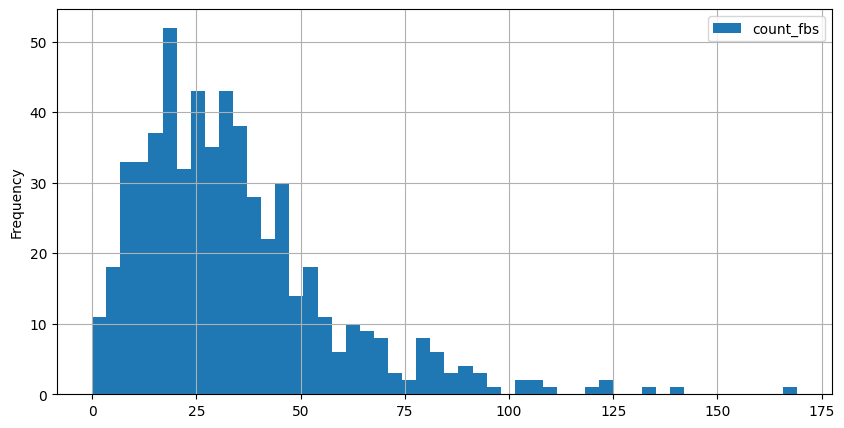

Диапазон нормального распределения: (0.0, 83.0)
Гистограмма, ограниченная диапазоном нормального распределения:


<Axes: ylabel='Frequency'>

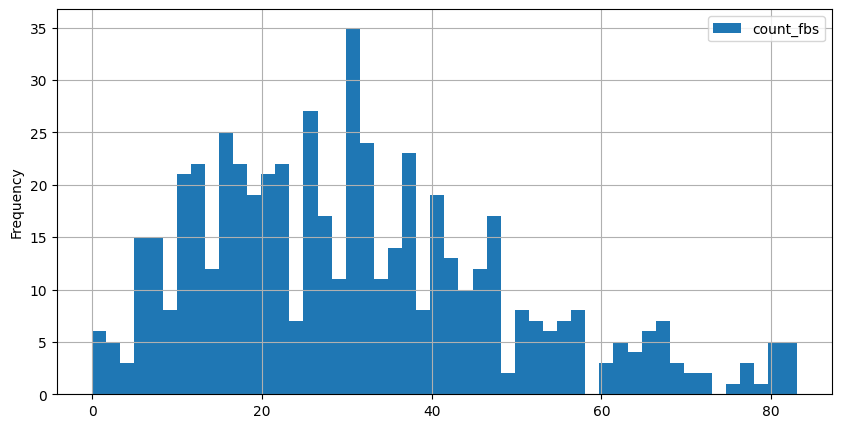

In [13]:
# Изучаемый столбец
column_name = 'count_fbs'

# График без ограничений
print('Гистограмма без ограничений:')
shops_info.plot(
    kind='hist',
    y=column_name,
    bins=50,
    figsize=(10,5),
    grid=True
)
plt.show()

# График нормального распределения
print('Диапазон нормального распределения:', lim_normal_range(shops_info[column_name]))
print('Гистограмма, ограниченная диапазоном нормального распределения:')
shops_info.plot(
    kind='hist',
    y=column_name,
    bins=50,
    figsize=(10,5),
    grid=True,
    range = lim_normal_range(shops_info[column_name]) #ограничение через функцию
)

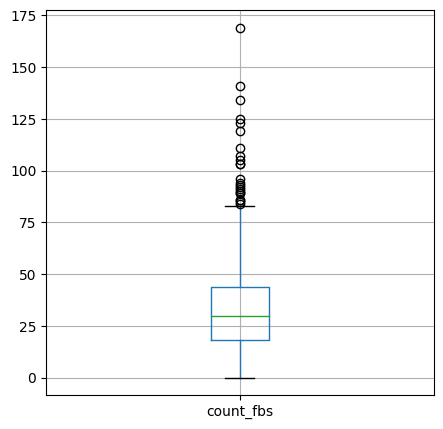

Числовое описание данных:


count    572.0
mean      34.0
std       23.4
min        0.0
25%       18.0
50%       30.0
75%       44.0
max      169.0
Name: count_fbs, dtype: float64

In [14]:
# Диаграмма размаха (Ящик с усами):
shops_info.boxplot(column=column_name, figsize=(5,5))
plt.show()
print('Числовое описание данных:')
round(shops_info[column_name].describe(),1)

Отзывы всегда будут, мы только можем минимизировать количество негативных отзывов и максимамзировать количество положительных отзывов. В среднем на магазин ставят 34  отзыва, а медианное значение 30. По распределению видно, что аномальными значения являются выше 75 отзывов, но это могут быть просто большие магазины, которые давно работают и чем больше человек приходит тем процент отзыва может быть больше или возможно есть вещи, которые стимулируют клиентов ставить отзывы.

In [15]:
# Посчитаем "шанс отзыва"
shops_info['per_neg_fb'] = (shops_info['count_fbs'] / shops_info['count_orders'] * 100).round(2)

print('Медианный шанс на отзыв', shops_info['per_neg_fb'].median())
display(shops_info.sort_values(by = 'count_orders', ascending = False).head(10))

Медианный шанс на отзыв 33.33


,shop,count_orders,min_review,max_review,median_review,count_fbs,per_neg_fb
167,store_0249,486,1.0,5.0,5.0,141,29.01
532,store_063,450,1.0,5.0,5.0,169,37.56
22,store_0118,340,1.0,5.0,5.0,111,32.65
82,store_0172,326,1.0,5.0,5.0,94,28.83
166,store_0248,310,1.0,5.0,5.0,125,40.32
87,store_0177,309,1.0,5.0,5.0,123,39.81
19,store_0115,307,1.0,5.0,5.0,89,28.99
324,store_0390,305,1.0,5.0,5.0,134,43.93
543,store_073,301,1.0,5.0,5.0,84,27.91
552,store_081,300,1.0,5.0,5.0,79,26.33


Можно сказать, что шанс получить отзыв при покупке около 33 процентов. В каких-то магазинах больше или меньше

In [16]:
display(shops_info.sort_values(by = 'per_neg_fb', ascending = False).head(10))
display(shops_info.sort_values(by = 'per_neg_fb', ascending = True).head(10))

,shop,count_orders,min_review,max_review,median_review,count_fbs,per_neg_fb
513,store_0560,1,5.0,5.0,5.0,1,100.00
464,store_0516,59,1.0,5.0,3.0,38,64.41
183,store_0263,64,1.0,5.0,4.0,41,64.06
309,store_0377,49,1.0,5.0,4.0,30,61.22
373,store_0434,63,1.0,5.0,5.0,38,60.32
212,store_029,134,1.0,5.0,4.0,80,59.70
522,store_0569,7,2.0,5.0,5.0,4,57.14
99,store_0188,140,1.0,5.0,4.0,78,55.71
17,store_0113,62,1.0,5.0,4.0,34,54.84
498,store_0547,22,1.0,5.0,5.0,12,54.55


,shop,count_orders,min_review,max_review,median_review,count_fbs,per_neg_fb
520,store_0567,1,5.0,5.0,5.0,0,0.00
524,store_0570,1,5.0,5.0,5.0,0,0.00
510,store_0558,18,3.0,5.0,5.0,1,5.56
409,store_0467,43,3.0,5.0,5.0,6,13.95
417,store_0474,27,3.0,5.0,5.0,4,14.81
380,store_0440,67,1.0,5.0,5.0,10,14.93
353,store_0416,46,2.0,5.0,5.0,7,15.22
215,store_0292,81,1.0,5.0,5.0,13,16.05
284,store_0354,36,1.0,5.0,5.0,6,16.67
352,store_0415,36,1.0,5.0,5.0,6,16.67


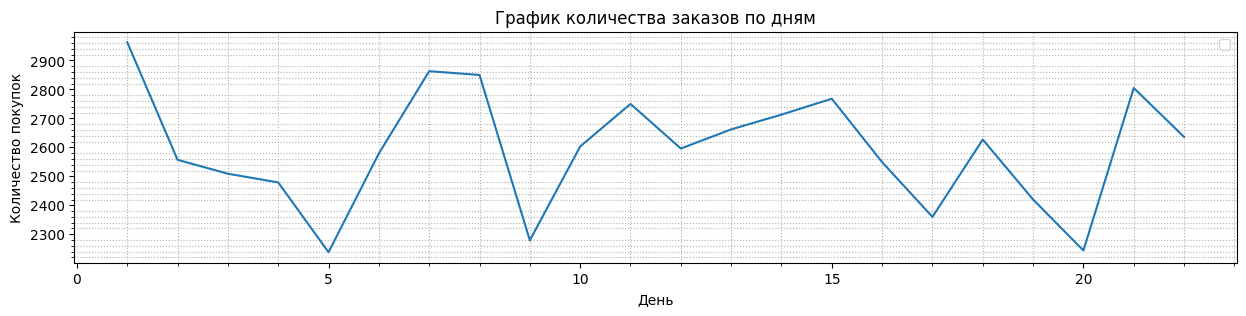

In [17]:
# Столбец дня
df['day'] = df['date'].dt.day

# Данные для графика
for_plot_1 = df.groupby('day')['order_number'].count().reset_index()

# Настройки графика
plt.figure(figsize=(15, 3))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.title('График количества заказов по дням')
plt.xlabel('День')
plt.ylabel('Количество покупок')

# Строим график количества покупок по дням
plt.plot(for_plot_1['day'], for_plot_1['order_number'])

plt.legend()
plt.show()

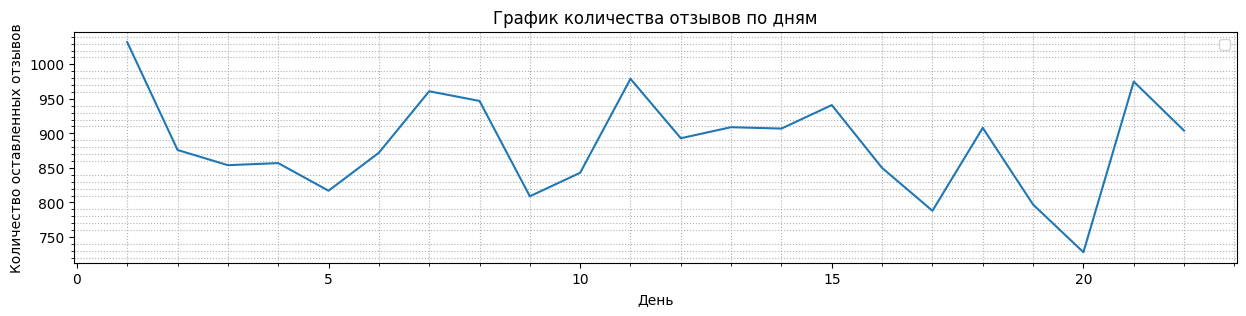

In [18]:
# Данные для графика
for_plot_2 = df.groupby('day')['feedback'].count().reset_index()

# Настройки графика
plt.figure(figsize=(15, 3))
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.title('График количества отзывов по дням')
plt.xlabel('День')
plt.ylabel('Количество оставленных отзывов')

# Строим график количества покупок по дням
plt.plot(for_plot_2['day'], for_plot_2['feedback'])

plt.legend()
plt.show()

### Дата

In [19]:
# Посмотрим на данные от и до
print('Даты заказов с',df.date.min(),'до',df.date.max())

Даты заказов с 2011-06-01 00:04:28 до 2011-06-22 23:54:01


Мы имеем данные июня 2011 года с 1 по 22 число

In [20]:
# Временные столбцы
df['date_wo_time'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df['weekday'] = df['date'].dt.weekday + 1
df['hour_start'] = df['date'].round('H')
df['hour'] = df['hour_start'].dt.hour

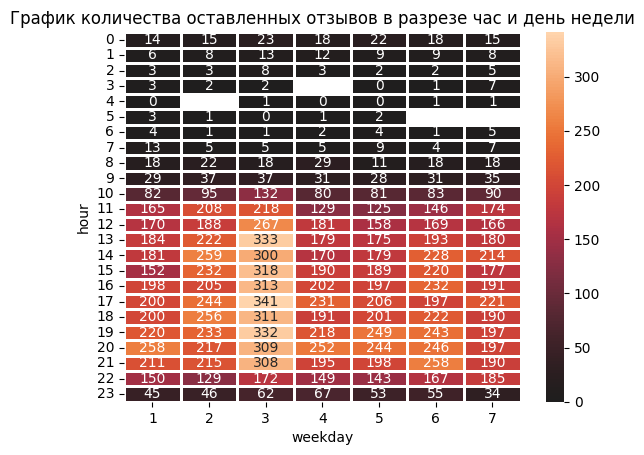

In [21]:
fb_count_hm = sns.heatmap(
    pd.pivot_table(
        data=df,
        index="hour",
        columns="weekday",
        values="feedback",
        aggfunc="count",
    ),
    annot=True,
    fmt=".0f",
    center=0,
    linewidth=1,
)
fb_count_hm.set_title(
    "График количества оставленных отзывов в разрезе час и день недели"
)
plt.show()

Ночью и утром ставят мало отзывов. А вот днем ставят больше. Причем среда прям пик активности. Почти каждый час это лучшее значение из всех дней недели.
Возможно в среду сотрудники больше спрашивают отзывы, возможно люди закупаются на выходных и в первые рабочие дни полуают смс с просьбой оставить отзыв или откладывают до среды или другого дня.

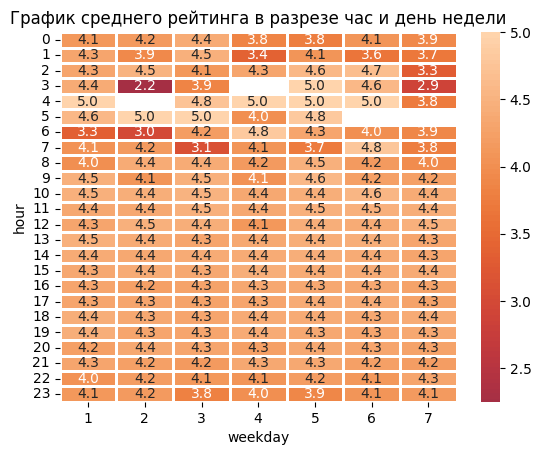

In [22]:
rw_mean_hm = sns.heatmap(
    pd.pivot_table(
        data=df,
        index="hour",
        columns="weekday",
        values="review",
        aggfunc="mean",
    ),
    annot=True,
    fmt=".1f",
    center=0,
    linewidth = 1,
)
rw_mean_hm.set_title(
    "График среднего рейтинга в разрезе час и день недели"
)
plt.show()

В будни средний рейтинг держится примерно на одном уровне около 4,4. То что ночью есть меньше или больше средняя оценка, думаю на это больше влияет количество покупок и как следствие количество оставленных отзывов

### Статус

In [23]:
# Уникальные значения по статусу
df.status.unique()

<StringArray>
['Не проверен', 'Проверен']
Length: 2, dtype: string

In [24]:
status_info = df.groupby('status')['order_number'].count().reset_index()
status_info['perc_stat'] = (status_info['order_number'] / status_info['order_number'].sum() * 100).round(2)

display(status_info)

,status,order_number,perc_stat
0,Не проверен,56602,99.21
1,Проверен,448,0.79


Менее одного процента заказов проверен. Процент слишком мал, чтобы рассматривать в данной плоскости данные

Чтобы это не значило. Необходима дополнительная информация

In [25]:
status_fb_info = df.groupby('status')['feedback'].count().reset_index()
status_fb_info['perc_stat'] = (status_fb_info['feedback'] / status_fb_info['feedback'].sum() * 100).round(2)

display(status_fb_info)

,status,feedback,perc_stat
0,Не проверен,19054,97.98
1,Проверен,393,2.02


По количеству отзывов тоже тяжело, что сказать. Статистически только 2% отзывов проверяют

### Rewies and Feedbacks

In [26]:
# Посмотрим на количество оставленных отзывов в разрезе оценок
rev_fd_info = df.groupby('review')['feedback'].count().reset_index()
rev_fd_info['perc_fbs'] = (rev_fd_info['feedback'] / rev_fd_info['feedback'].sum() * 100).round(2)

display(rev_fd_info)

# Построю визуализацию
pie_1 = px.pie(
    rev_fd_info,
    values="feedback",
    names="review",
    title="Круговая диаграмма по отзывам",
    hole=0.3,
)
pie_1.show()

,review,feedback,perc_fbs
0,1.0,4668,24.00
1,2.0,2087,10.73
2,3.0,3016,15.51
3,4.0,2452,12.61
4,5.0,7224,37.15


У нас есть первая классификация: по оценке.

Чаще всего клиенты оставляют положительные отзывы, около 37%

In [27]:
# Заполню пустоты
columns = ['feedback','text_1','other_text']

for column in columns:
  df[column] = df[column].fillna('Пусто')

In [28]:
# Посмотрим на text_1
display(df.query('text_1 != "Пусто"').head(20))

,shop,order_number,date,status,review,feedback,text_1,text_2,other_text,day,date_wo_time,weekday,hour_start,hour
61,store_055,45R11094381417,2011-06-19 09:03:49,Не проверен,1.0,заказ ехал более 12 часов,заказ ехал более 12 часов,<NA>,Пусто,19,2011-06-19 09:03:49,7,2011-06-19 09:00:00,9
79,store_067,1813334300177R,2011-06-19 09:33:07,Не проверен,1.0,"Заказ был сделан в 11 часов, привезен в 13.30!...","Заказ был сделан в 11 часов, привезен в 13.30!...",<NA>,Пусто,19,2011-06-19 09:33:07,7,2011-06-19 10:00:00,10
427,store_0132,4560117199414R,2011-06-19 11:59:46,Не проверен,1.0,Пусто,Без описания,<NA>,Пусто,19,2011-06-19 11:59:46,7,2011-06-19 12:00:00,12
500,store_066,15112490R31624,2011-06-19 12:22:31,Не проверен,1.0,Пусто,Без описания,<NA>,Пусто,19,2011-06-19 12:22:31,7,2011-06-19 12:00:00,12
562,store_0327,54121R11524891,2011-06-19 12:48:29,Проверен,1.0,"Побыстрее, конечно, чем в прошлый раз... А кур...","Побыстрее, конечно, чем в прошлый раз... А кур...",<NA>,Пусто,19,2011-06-19 12:48:29,7,2011-06-19 13:00:00,13
662,store_0249,554215R1122491,2011-06-19 13:22:59,Не проверен,2.0,"Курьер не понимал куда идти, мороженное не при...","Курьер не понимал куда идти, мороженное не при...",<NA>,"Курьер не понимал куда идти, мороженное не при...",19,2011-06-19 13:22:59,7,2011-06-19 13:00:00,13
738,store_067,3432R411211685,2011-06-19 13:46:28,Не проверен,3.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 13:46:28,7,2011-06-19 14:00:00,14
774,store_068,40725110219R29,2011-06-19 14:02:29,Не проверен,2.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 14:02:29,7,2011-06-19 14:00:00,14
1070,store_0415,044331197714R5,2011-06-19 15:30:47,Не проверен,1.0,Не довезли товар. Клубнику прислали отвратител...,Не довезли товар. Клубнику прислали отвратител...,<NA>,Не довезли товар. Клубнику прислали отвратител...,19,2011-06-19 15:30:47,7,2011-06-19 16:00:00,16
1724,store_0253,R5517714540181,2011-06-19 18:57:45,Не проверен,1.0,Ждала заказ более двух часов. Назначили двух к...,Ждала заказ более двух часов. Назначили двух к...,<NA>,Пусто,19,2011-06-19 18:57:45,7,2011-06-19 19:00:00,19


In [29]:
# Посмотрим на other_text
df_other_text = df.query('other_text != "Пусто"')
display(df_other_text.head(20))
print(len(df_other_text))

,shop,order_number,date,status,review,feedback,text_1,text_2,other_text,day,date_wo_time,weekday,hour_start,hour
4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3.0,Пусто,Пусто,<NA>,Без описания,19,2011-06-19 00:27:02,7,2011-06-19 00:00:00,0
12,store_011,411R8214404085,2011-06-19 01:04:44,Не проверен,2.0,Очень плохой арбуз прислали. Тухлый,Пусто,<NA>,Очень плохой арбуз прислали. Тухлый,19,2011-06-19 01:04:44,7,2011-06-19 01:00:00,1
14,store_013,4R564110131631,2011-06-19 01:31:14,Не проверен,2.0,"Мороженное все помятое как будто его пинали, с...",Пусто,<NA>,"Мороженное все помятое как будто его пинали, с...",19,2011-06-19 01:31:14,7,2011-06-19 02:00:00,2
15,store_014,1516432R122140,2011-06-19 02:30:22,Не проверен,3.0,Добрый вечер! Перекись водорода не приехала,Пусто,<NA>,Добрый вечер! Перекись водорода не приехала,19,2011-06-19 02:30:22,7,2011-06-19 03:00:00,3
18,store_017,1R140032751474,2011-06-19 04:27:40,Не проверен,1.0,"Быстро собрали, да, прикольно. Но даже не удос...",Пусто,<NA>,"Быстро собрали, да, прикольно. Но даже не удос...",19,2011-06-19 04:27:40,7,2011-06-19 04:00:00,4
51,store_046,21134R10444483,2011-06-19 08:48:30,Не проверен,2.0,"морковь мелкая, капуста гнилая насквозь, пришл...",Пусто,<NA>,"морковь мелкая, капуста гнилая насквозь, пришл...",19,2011-06-19 08:48:30,7,2011-06-19 09:00:00,9
67,store_043,1344R859311871,2011-06-19 09:18:35,Не проверен,3.0,Пусто,Пусто,<NA>,Без описания,19,2011-06-19 09:18:35,7,2011-06-19 09:00:00,9
69,store_060,1421411660R631,2011-06-19 09:21:01,Не проверен,1.0,Положили не тот творог,Пусто,<NA>,Положили не тот творог,19,2011-06-19 09:21:01,7,2011-06-19 09:00:00,9
80,store_068,13117436199R24,2011-06-19 09:33:17,Не проверен,2.0,"Ребята, нафига вы опять делаете замены? У меня...",Пусто,<NA>,"Ребята, нафига вы опять делаете замены? У меня...",19,2011-06-19 09:33:17,7,2011-06-19 10:00:00,10
81,store_069,94103140R87170,2011-06-19 09:39:07,Не проверен,2.0,"Заказывала 0,473, а привезли 0,355",Пусто,<NA>,"Заказывала 0,473, а привезли 0,355",19,2011-06-19 09:39:07,7,2011-06-19 10:00:00,10


6401


In [30]:
# Посмотрим на то если текст в text_1 и в text_other
display(df_other_text.query('text_1 != "Пусто"').head(20))
print(len(df_other_text.query('text_1 != "Пусто"')))

,shop,order_number,date,status,review,feedback,text_1,text_2,other_text,day,date_wo_time,weekday,hour_start,hour
662,store_0249,554215R1122491,2011-06-19 13:22:59,Не проверен,2.0,"Курьер не понимал куда идти, мороженное не при...","Курьер не понимал куда идти, мороженное не при...",<NA>,"Курьер не понимал куда идти, мороженное не при...",19,2011-06-19 13:22:59,7,2011-06-19 13:00:00,13
738,store_067,3432R411211685,2011-06-19 13:46:28,Не проверен,3.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 13:46:28,7,2011-06-19 14:00:00,14
774,store_068,40725110219R29,2011-06-19 14:02:29,Не проверен,2.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 14:02:29,7,2011-06-19 14:00:00,14
1070,store_0415,044331197714R5,2011-06-19 15:30:47,Не проверен,1.0,Не довезли товар. Клубнику прислали отвратител...,Не довезли товар. Клубнику прислали отвратител...,<NA>,Не довезли товар. Клубнику прислали отвратител...,19,2011-06-19 15:30:47,7,2011-06-19 16:00:00,16
1789,store_0223,41651R14380110,2011-06-19 19:18:35,Не проверен,1.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 19:18:35,7,2011-06-19 19:00:00,19
1912,store_0494,2401112R785164,2011-06-19 19:52:47,Не проверен,1.0,Здравствуйте! Не довезли 1 слойку! В заказе 2...,Здравствуйте! Не довезли 1 слойку! В заказе 2...,<NA>,Здравствуйте! Не довезли 1 слойку! В заказе 2...,19,2011-06-19 19:52:47,7,2011-06-19 20:00:00,20
1994,store_0251,011R1675114716,2011-06-19 20:17:10,Не проверен,3.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 20:17:10,7,2011-06-19 20:00:00,20
2014,store_0165,371414211R5263,2011-06-19 20:21:53,Не проверен,3.0,"Котлеты из говядины были вскрыты, Пеп си заказ...","Котлеты из говядины были вскрыты, Пеп си заказ...",<NA>,"Котлеты из говядины были вскрыты, Пеп си заказ...",19,2011-06-19 20:21:53,7,2011-06-19 20:00:00,20
2061,store_0502,11227R14119632,2011-06-19 20:31:12,Не проверен,2.0,Пусто,Без описания,<NA>,Без описания,19,2011-06-19 20:31:12,7,2011-06-19 21:00:00,21
2065,store_0215,632246911R1212,2011-06-19 20:32:29,Не проверен,1.0,Заказ не мой,Заказ не мой,<NA>,Заказ не мой,19,2011-06-19 20:32:29,7,2011-06-19 21:00:00,21


422


В целом видно, что это дубль основной вкладки. Заполним feedback данным из остальных столбцов

In [31]:
print('До объединения мы имеем', df.query('feedback != "Пусто"')['feedback'].count(),'строчек')

# Заполняем пустоты
for i in range(len(df)):
  if df.loc[i]['feedback'] == 'Пусто':
    if df.loc[i]['text_1'] != 'Пусто':
      df.loc[i,['feedback']] = df.loc[i]['text_1']
    elif df.loc[i]['other_text'] != 'Пусто':
      df.loc[i,['feedback']] = df.loc[i]['other_text']

print('После объединения мы имеем', df.query('feedback != "Пусто"')['feedback'].count(),'строчек')

До объединения мы имеем 19447 строчек
После объединения мы имеем 20393 строчек


Добавил 946 строчек. Остальные столбцы не нужны, но оставлю их пока, может пригодятся

In [32]:
# Посмотрим на количество оставленных отзывов в разрезе оценок
rev_fd_aft_info = df.query('feedback != "Пусто"').groupby('review')['feedback'].count().reset_index()
rev_fd_aft_info['perc_fbs'] = (rev_fd_aft_info['feedback'] / rev_fd_aft_info['feedback'].sum() * 100).round(2)

print('Данные до объединения')
display(rev_fd_info)
print('Данные после объединения')
display(rev_fd_aft_info)

# Построю визуализацию
pie_2 = px.pie(
    rev_fd_aft_info,
    values="feedback",
    names="review",
    title="Круговая диаграмма по отзывам после добавления данных",
    hole=0.3,
)
pie_2.show()

Данные до объединения


,review,feedback,perc_fbs
0,1.0,4668,24.00
1,2.0,2087,10.73
2,3.0,3016,15.51
3,4.0,2452,12.61
4,5.0,7224,37.15


Данные после объединения


,review,feedback,perc_fbs
0,1.0,5128,25.15
1,2.0,2310,11.33
2,3.0,3279,16.08
3,4.0,2452,12.02
4,5.0,7224,35.42


In [33]:
rev_fd_info_added = rev_fd_info.copy()
rev_fd_info_added['new_fb'] = rev_fd_aft_info['feedback']
rev_fd_info_added['diff'] = rev_fd_info_added['new_fb'] - rev_fd_info_added['feedback']

display(rev_fd_info_added)

,review,feedback,perc_fbs,new_fb,diff
0,1.0,4668,24.00,5128,460
1,2.0,2087,10.73,2310,223
2,3.0,3016,15.51,3279,263
3,4.0,2452,12.61,2452,0
4,5.0,7224,37.15,7224,0


Добавились по большей части негативные отзывы. Больше всего 460 с рейтингом 1

Отзывы "Без описания"
Таких отзывов 946 из 20393


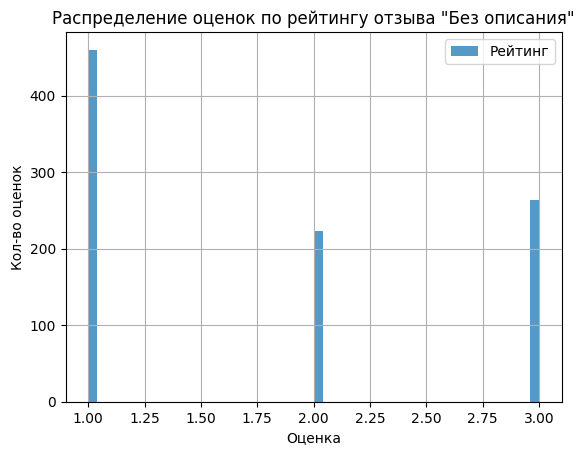

In [34]:
# Без описания
# При просмотре данных были такие отзывы. Думаю их можно выделить отдельно

no_discription = df.query('feedback == "Без описания"')
print('Отзывы "Без описания"')
print('Таких отзывов',no_discription.feedback.count(),'из', rev_fd_info_added.new_fb.sum())

no_discription['review'].hist(bins=50, label='Рейтинг', alpha=0.75)
plt.legend()
plt.xlabel('Оценка')
plt.ylabel('Кол-во оценок')
plt.title('Распределение оценок по рейтингу отзыва "Без описания"');

Выделил категорию "Без описания". Редко, когда не оставляют никакого текста на негативный отзыв

Посмотрим на что еще жалуются люди

In [35]:
df.query('feedback != "Пусто"').head(20)

,shop,order_number,date,status,review,feedback,text_1,text_2,other_text,day,date_wo_time,weekday,hour_start,hour
3,store_03,4R556131941173,2011-06-19 00:13:57,Не проверен,3.0,долго заказ ждал... хотя доставку оплату повыс...,Пусто,<NA>,Пусто,19,2011-06-19 00:13:57,7,2011-06-19 00:00:00,0
4,store_04,1117R271442037,2011-06-19 00:27:02,Не проверен,3.0,Без описания,Пусто,<NA>,Без описания,19,2011-06-19 00:27:02,7,2011-06-19 00:00:00,0
5,store_05,3R111814004475,2011-06-19 00:30:14,Не проверен,1.0,"Персики дубовые , зуб можно сломать !!!!",Пусто,<NA>,Пусто,19,2011-06-19 00:30:14,7,2011-06-19 01:00:00,1
9,store_08,035004185R1135,2011-06-19 00:50:05,Не проверен,1.0,"Здравствуйте! Ужасно! Я заказывала огурцы, огу...",Пусто,<NA>,Пусто,19,2011-06-19 00:50:05,7,2011-06-19 01:00:00,1
10,store_09,516365424122R1,2011-06-19 00:56:22,Не проверен,2.0,Мясо купили с одним жиром,Пусто,<NA>,Пусто,19,2011-06-19 00:56:22,7,2011-06-19 01:00:00,1
12,store_011,411R8214404085,2011-06-19 01:04:44,Не проверен,2.0,Очень плохой арбуз прислали. Тухлый,Пусто,<NA>,Очень плохой арбуз прислали. Тухлый,19,2011-06-19 01:04:44,7,2011-06-19 01:00:00,1
14,store_013,4R564110131631,2011-06-19 01:31:14,Не проверен,2.0,"Мороженное все помятое как будто его пинали, с...",Пусто,<NA>,"Мороженное все помятое как будто его пинали, с...",19,2011-06-19 01:31:14,7,2011-06-19 02:00:00,2
15,store_014,1516432R122140,2011-06-19 02:30:22,Не проверен,3.0,Добрый вечер! Перекись водорода не приехала,Пусто,<NA>,Добрый вечер! Перекись водорода не приехала,19,2011-06-19 02:30:22,7,2011-06-19 03:00:00,3
16,store_015,841153522R3144,2011-06-19 02:54:53,Не проверен,4.0,В чеке сыр Сливочный. По факту положили сыр Фи...,Пусто,<NA>,Пусто,19,2011-06-19 02:54:53,7,2011-06-19 03:00:00,3
17,store_016,4424116R702791,2011-06-19 03:29:26,Не проверен,2.0,Цены в чеке неадекватные. Творог по 1 рублю?? ...,Пусто,<NA>,Пусто,19,2011-06-19 03:29:26,7,2011-06-19 03:00:00,3


Посчитаем слова в отзывах

In [49]:
list_of_fb = []
fb_true = df.query('feedback != "Пусто"').reset_index()

for i in range(len(fb_true)):
  for text in fb_true.loc[i]['feedback'].lower().split(' '):
    r_text = re.sub("[^A-Za-z]", '', text)
    list_of_fb.append(text)

In [50]:
# Составим словарь уникальных значений (слов) и количество их упоминаний
counts = dict()
for word in list_of_fb:
        # если слово уже есть в словаре, увеличиваем счетчик
  if word in counts:
    counts[word] += 1
  else: # если нет, добавляем слово в словарь
    counts[word] = 1

In [66]:
# Переведем словарь в форму DataFrame
indexs = []
values = []
for i in counts:
  indexs.append(i)
  values.append(counts[i])

words_count = pd.DataFrame(index = indexs, data = values).reset_index()
words_count.columns = ['word','count']
# Выведем дф
display(words_count.head())

,word,count
0,долго,216
1,заказ,1405
2,ждал...,1
3,хотя,437
4,доставку,256


In [68]:
# Отфильтруем по количеству
display(words_count.sort_values(by = 'count', ascending = False).head(25))

,word,count
27,не,10189
25,в,7298
149,и,7045
48,все,3914
81,на,2902
39,с,2888
181,привезли,2808
245,что,2681
180,спасибо,2213
42,очень,2077


In [89]:
for i in range(len(fb_true)):
  index = fb_true.loc[i]['feedback'].find(" спасибо ")
  if index != -1:
    print(fb_true.loc[index]['feedback'])

Спасибо за бережную продуманную упаковку, хороший выбор продуктов, быструю  доставку!
Добрый вечер! Перекись водорода не приехала
Добрый вечер! Перекись водорода не приехала
5/5
Всё понравилось! Всё свежее!
Курьер вежливый!
Всем хорошего дня!!!
Но сырки глазированные помяли.
Цены в чеке неадекватные. Творог по 1 рублю?? Из за таких странностей мне начислен некорректно кэшбэк за любимый продукт.
В заказ забыли положить мороженое😪просьба стоимость товара вернуть на карту
Не привезли часть заказа! Заказ состоял из 3 пакетов, 1 пакет просто не привезли. Деньги не вернули. Просто ужас а не обслуживание
Без описания
Быстро, четко, спасибо
В чеке сыр Сливочный. По факту положили сыр Финский той же фирмы. Только вот Финский дешевле на 29.1р. Прошу вернуть разницу
То торт положили уценённый, который живёт до завтра и всё; то сыр положили 242гр из 400гр., зафасованный вчера вообще и выглядит будто его в тепле держали, задрипанный такой кусочек; мороженое всегда кладут ко всем остальным товарам, 

Можно по ключевым словам выделить категории отзывов:

Слова спасибо, вы супер, 5/5, быстрая доставка можно отнести к благодарностям.   
Слова курьер, не положили, не приехала отнести к проблемам с доставкой.  
Слова привезли не тот, нет товара отнести к проблемам со сборкой товара.  
Слова цены, цена, в чеке отнести к вопросам ценообразования(возможно технические сложности).  
Слово кешбек к кешбекам

Думаю можно много еще найти таких слов ключей, к которым можно отнести тот или иной отзыв. Можно использовать составленный мною словарь или по словам вести поиск.

# Вывод

Были получены данные по заказам доставки из магазинов X5 за июнь 2011 года с 1 по 22 число.

Выполнена преобработка данных. Исправление названий столбцов, заполнение пустот, исправление формата столбцов и добавление новых столбцов

Анализ работы показал, что есть информация по 572 магазинам, в которых было выполнено 57050 заказов. Присутствуют как новые магазины, так и старые. Медианое количество заказов 84 на один магазин, а медианое значение оставленных отзывов на магазин 30. Есть магазины, где отзывы оставляют чаще, где-то реже. Медианый шанс получить отзыв около 1/3.

Отзывы оставляют чаще всего в среду на протяжении всего дня. В компании есть система по проверке отзывов. Но работает она слабо, около 2% всех отзывов было проверено. Если смотреть по заказам, то тут меньше 1% было проверено.
В данных есть оценка от пользователя. Она разнится от 1 до 5, где 5 лучшая оценка. Чаще всего оставляют именно положительные оценки, около 37% это оценка 5. Второе место занимает оценка 1, около 24%. Остальные оценки набирают от 10 до 15%.  
Это первая категоризации отзывов, которая уже есть и работает.

Были замечены столицы дубли для внесения комментариев. После объединения столбцов было добавлено 946 отзыва. Больше всего негативных, рейтинг 1.

Был разработан механизм по подсчету уникальных слов в тексте отзыва, которые в последующем можно было бы отнести к новой категоризации отзывов. Разделение на: благодарность, ошибки с ценами, проблемы с кешбеком, доставкой товара, привезли другой товар и другие
